# Data Sampling from Marchetti etl. al 2021

The results published by Marchetti et. al 2021 consist of the grain size information for the sand banks along the Po river in Italy.

The dataset used here has first been processed in QGIS to extract the centroids of each raster data point and then convert those to EPSG4326. These data points are then extracted along with their D50 values and stored in a CSV file. 

We further process that CSV file to conduct a stratified random sampling of sub-points that we use in other analysis

In [2]:
import numpy as np
import pystac_client
import planetary_computer
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from datetime import datetime

In [26]:
df = pd.read_csv('../../data/Marchetti-2021-regression-output.csv')
df

,D50,lon,lat
0,31.491240,7.896412,45.182873
1,31.491240,7.896412,45.182783
2,32.134602,7.896285,45.182693
3,36.287048,7.920829,45.182064
4,37.224495,7.918540,45.181974
...,...,...,...
40426,2.867297,10.361710,44.963835
40427,4.460123,10.361837,44.963835
40428,8.240463,10.361964,44.963835
40429,8.189078,10.361328,44.963746


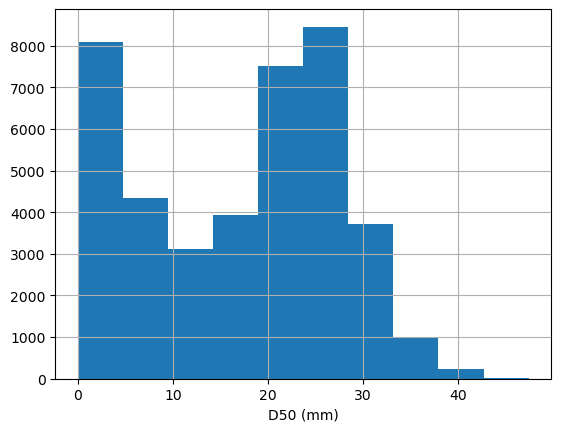

In [4]:
df['D50'].hist()
plt.xlabel('D50 (mm)')
plt.show()

## Set dates

"drone flights were conducted on 20 and 21 September 2018 in the Po and Sesia rivers, respectively (sites P1 and S1, Figure 1) and on 23 and 24 October 2018 in the Bonamico River (sites B1 and B2, Figure 1). Dates of flight were characterized by sunny and dry conditions"

In [27]:
sampling_date = '2018-09-22' #took median date

sampling_date = datetime.strptime(sampling_date, '%Y-%m-%d').date()

df['date'] = sampling_date
df


,D50,lon,lat,date
0,31.491240,7.896412,45.182873,2018-09-22
1,31.491240,7.896412,45.182783,2018-09-22
2,32.134602,7.896285,45.182693,2018-09-22
3,36.287048,7.920829,45.182064,2018-09-22
4,37.224495,7.918540,45.181974,2018-09-22
...,...,...,...,...
40426,2.867297,10.361710,44.963835,2018-09-22
40427,4.460123,10.361837,44.963835,2018-09-22
40428,8.240463,10.361964,44.963835,2018-09-22
40429,8.189078,10.361328,44.963746,2018-09-22


# Conduct Stratified Random Sampling

## First separate into classes according to the wentworth scale

![WC](../../img/wentworth.png)

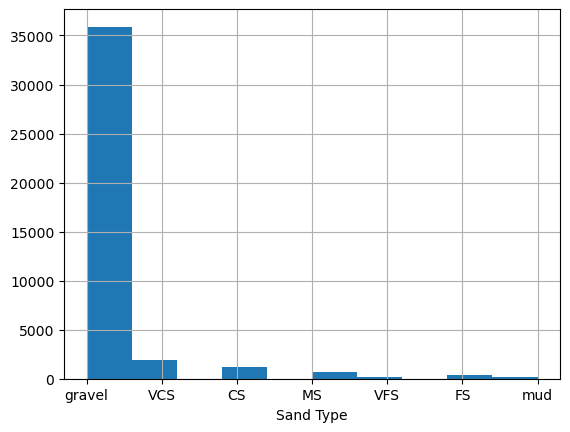

In [28]:
bins = [0, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 250.,]
labels = ['mud', 'VFS','FS','MS','CS','VCS','gravel']
df['type'] = pd.cut(x = df['D50'], bins = bins, labels = labels, include_lowest = True)
df['type'].hist()
plt.xlabel('Sand Type')
plt.show()

## Create another labeling system according to usefulness

[Reuters]() says __useful__ sand is between 0.6 and 2mm diameters. The consensus on the scant reports online seem to indicate the range is probably looser. 

So we will adopt a wider range and encompass medium coarse and very coarse sand as the useful category, designated as 'at', and smaller sizes being 'below' and larger sizes being 'above'.

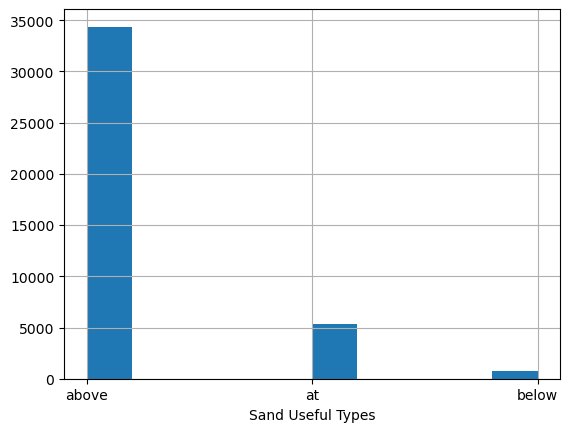

In [29]:
bins = [0, 0.25, 3., 250.]
labels = ['below','at','above']
df['useful'] = pd.cut(x = df['D50'], bins = bins, labels = labels, include_lowest = True)
df['useful'].hist()
plt.xlabel('Sand Useful Types')
plt.show()

Sample N observations from each category

In [30]:
df.max()

D50        47.404659
lon        10.377733
lat        45.182873
date      2018-09-22
type          gravel
useful         above
dtype: object

In [31]:
marchetti_sample = df.groupby('useful', group_keys=False).apply(lambda x: x.sample(20)).copy()
marchetti_sample.index.name = 'objectid'
marchetti_sample

,D50,lon,lat,date,type,useful
objectid,,,,,,
33784,0.157863,9.879739,45.120741,2018-09-22,FS,below
34640,0.102523,9.886352,45.112648,2018-09-22,VFS,below
35993,0.210340,10.037174,45.080188,2018-09-22,FS,below
30229,0.026007,9.643459,45.109411,2018-09-22,mud,below
37080,0.024874,10.162436,45.037388,2018-09-22,mud,below
35691,0.153149,10.035013,45.081267,2018-09-22,FS,below
37234,0.117689,10.157858,45.035589,2018-09-22,VFS,below
36288,0.025028,10.037810,45.077580,2018-09-22,mud,below
30262,0.092359,9.643586,45.108512,2018-09-22,VFS,below


In [33]:
marchetti_sample['dataset'] = 'marchetti'

In [32]:
len(marchett_sample)

70

array([[<AxesSubplot:title={'center':'D50'}>]], dtype=object)

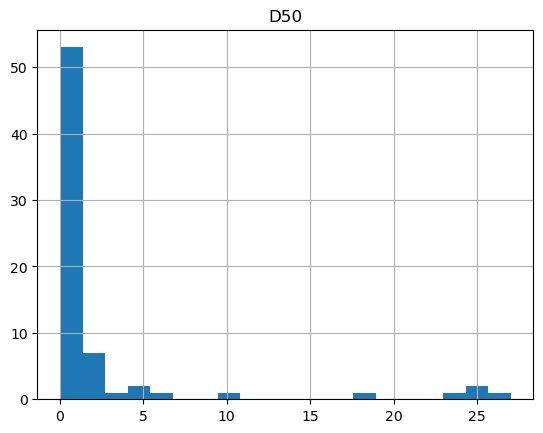

In [34]:
marchett_sample.hist('D50', bins=20)

In [35]:
marchett_sample.to_csv('../../data/marchetti-sample70-2.csv')

In [43]:
marchett_sample['date'] =  pd.to_datetime(marchett_sample['date'], infer_datetime_format=True).dt.date

# Interactive quality assessment

Let's use GEE

In [11]:
import subprocess

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

Installing geemap ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 60.9 MB/s eta 0:00:00
  Using cached ffmpeg_python-0.2.0-py3-none-any.whl (25 kB)
  Using cached sankee-0.2.3-py3-none-any.whl
  Using cached geocoder-1.38.1-py2.py3-none-any.whl (98 kB)
  Using cached geeadd-0.5.6-py3-none-any.whl (30 kB)
  Using cached eerepr-0.0.4-py3-none-any.whl (9.7 kB)
  Using cached ee_extra-0.0.15-py3-none-any.whl
  Using cached pyperclip-1.8.2-py3-none-any.whl
  Using cached earthengine_api-0.1.345-py3-none-any.whl
  Using cached google_api_python_client-2.81.0-py2.py3-none-any.whl (11.1 MB)
  Using cached google_auth_httplib2-0.1.0-py2.py3-none-any.whl (9.3 kB)
  Using cached httplib2-0.21.0-py3-none-any.whl (96 kB)
  Using cached logzero-1.7.0-py2.py3-none-any.whl (16 kB)
  Using cached plotly-5.13.1-py2.py3-none-any.whl (15.2 MB)
  Using cached ratelim-0.1.6-py2.py3-none-any.whl (4.0 kB)
  Using cached uritemplate-4.1.1-py2.py3-none-any.whl (10 kB)


In [36]:
!pip install localtileserver

  Using cached localtileserver-0.6.4-py3-none-any.whl (19.4 MB)
  Using cached server_thread-0.2.0-py3-none-any.whl (8.5 kB)
  Using cached Flask-2.2.3-py3-none-any.whl (101 kB)
  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)
  Using cached flask_restx-1.1.0-py2.py3-none-any.whl (2.8 MB)
  Using cached Flask_Caching-2.0.2-py3-none-any.whl (28 kB)
  Using cached large_image-1.20.1-py3-none-any.whl (70 kB)
  Using cached Flask_Cors-3.0.10-py2.py3-none-any.whl (14 kB)
  Using cached itsdangerous-2.1.2-py3-none-any.whl (15 kB)
  Using cached aniso8601-9.0.1-py2.py3-none-any.whl (52 kB)
  Using cached palettable-3.3.0-py2.py3-none-any.whl (111 kB)
  Using cached large_image_source_gdal-1.20.1-py3-none-any.whl (21 kB)
  Using cached cachelib-0.9.0-py3-none-any.whl (15 kB)


In [39]:
import ee
import geemap

In [40]:
BANDS = ["B2","B3","B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12"]

In [ ]:
ee.Initialize()

In [76]:

s2Collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                  .filterDate('2018-09-05','2018-10-01')\
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',15))\
                    .select(BANDS)

s2Mosaic = s2Collection.mosaic()
s2Mosaic_reproj = s2Collection.mosaic().reproject(crs = ee.Projection('EPSG:4326'), scale=10)
# s2Mosaic_reproj = s2Collection.mosaic().reproject(None,scale=10)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import time
from IPython.display import clear_output

def get_values(df, m):
    """
    """
    
    keep = False
    marker_list = []
    
    for index, sample in tqdm(df.iterrows(), total=df.shape[0]): #shape is required to tell tqdm the total elements
        center = ee.Geometry.Point(sample['lat'],sample['lon'])
        circle = center.buffer(5)
        m.addLayer(center, {'color':'1111FF'}, 'pt')
        m.addLayer(circle, {'color':'FF00FF'}, '10m circle')
        m.center_object(center, zoom=15)      
        
            
        sample['delta_days'] = 0.
        
        display(sample)
        inp = input("[{:} {:} {:}] Enter y to keep / anything else to discard: ".format(sample['D50'],  sample['lat'], sample['lon']))
        keep = inp == 'y'  
        # time.sleep(5)
        clear_output()
        
        
        if (keep):
            DNs_point = S2_data(sample['date'], sample['lon'], sample['lat'], window_size_px=1, markers=marker_list)
            print("Kept Observation")
            for b, band in enumerate(BANDS):
                # print(b, band)
                df[band].iloc[index] = DNs_point[b]

In [45]:
marchett_sample.iloc[0]['lat']

45.0663408543

In [77]:
Map = geemap.Map(center=[marchett_sample.iloc[0]['lat'], marchett_sample.iloc[0]['lon']], zoom=14)
Map.add_basemap("SATELLITE")
vis_params = {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}

#Map.centerObject(point, 8)
Map.addLayer(s2Mosaic, vis_params, "S2")
Map.addLayer(s2Mosaic_reproj, vis_params, "S2_reproj")
Map

Map(center=[45.0663408543, 9.694962705], controls=(WidgetControl(options=['position', 'transparent_bg'], widge…

In [ ]:
Map.

In [78]:
pt = ee.Geometry.Point([10.036792865, 45.0810872435])
rect = pt.buffer(5).bounds()
Map.addLayer(rect, {'color':'FFFF00'}, '10m buffer',)
Map.addLayer(pt, {'color':'1111FF'}, 'pt')
Map.center_object(pt, zoom=15)

In [63]:
sample = geemap.ee_to_numpy(s2med.clip(rect), region=rect)

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B2' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().


Main Issue:
    
    "Composites have no projection : Composite images created by reducing an image collection are able to produce pixels in any requested projection and therefore have no fixed output projection. Instead, composites have the default projection of WGS-84 with 1-degree resolution pixels. Composites with the default projection will be computed in whatever output projection is requested. A request occurs by displaying the composite in the Code Editor (learn about how the Code editor sets scale and projection), or by explicitly specifying a projection/scale as in an aggregation such as ReduceRegion or Export."

In [70]:
rect2 = pt.buffer(20).bounds()
sample = s2med.clip(rect2)
data = geemap.ee_to_numpy(s2Mosaic_reproj, region=circle1)

In [66]:
circle.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'dimensions': [1, 1],
   'origin': [10, 45],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'dimensions': [1, 1],
   'origin': [10, 45],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'dimensions': [1, 1],
   'origin': [10, 45],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'dimensions': [1, 1],
   'origin': [10, 45],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B6',
   'data_type': {'type': 'PixelType',
    'precision': 'do

In [ ]:
data = ee.Image.get(s2Mosaic_reproj, region=circle1)